# IBM Data Science Final Capstone Project

## An Investigation Of Possible Locations For My Future Apartment Based On Specific Requirements

### Author: Sergey Kosenko<br/><br/>




**The report of the Capstone project can be found by the following link:**

https://www.dropbox.com/s/fgc2fauvul4j87a/0%20REPORT%20-%20IBM%20Data%20Science%20-%20Final%20Capstone%20Project%20WATSON%20STUDIO.pdf?dl=1 <br/><br/>

## 0. A Descriptive part of the Capstone Final Project

**Introduction**

This year a several important events await me:
    
1. Buy a new apartment

2. My child must go to school at the first grade
    
So, I have decided to develop a solution which can help me define areas in my city, which I have to consider when buying an apartment.
Additionaly I setup some requirements which should be completed during an implementation of this solution:

1. Desired distance from apartments to any underground

It should be **no more than 1500 meters**. As it is the quickest way to go around the city (except for a personal car)

2. Desired distance from a house in question to any school (in meters):

It should be **no more than 1000 meters**. As it is easier and safier to my child go to at school himself. Otherwise I have to accompany him.

3. Interesting places (for rest, art and sport) should be nearby of possible home locations.

If no interesting places will be nearby of possible home locations it does not make sense to buy apartments there as it will be very boring life

It's quite important problem for me:
1. The good education defines the future life and success of children.
2. Apartments are expensive and it's absolutely important to make a right choice and buy the best appropriate apartments.
So I am absolutely interested in receiving good results during the project

**Data Description**

For my analysis I will use the following datasets in approaches:

1. A list of Samara's school published on an official governemnt site: https://samadm.ru/city_life/obrazovanie/shkoly/the-list-of-schools/
2. A manually prepared list of metro (underground) stations: https://www.dropbox.com/s/9in85psy0tqb266/samara_underground.csv?dl=1
3. The data received via Foursquare API for finding venues nearby possible home locations

During the Capstone Project I will also use the following approaches:
1. Here Maps API that to get coordinates for each of the Samara's schools
2. Google Translate API that to translate the source data in Engligh as originally some of them in Russian
3. Folium for visualisation data on map

## PART 1

## 1. Import on necessary libraries for project

In [1]:
import numpy as np # library to handle data in a vectorized manner


import pandas as pd # library for data analsysis
# specific setting for a better appearance
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None  # default='warn'

import json # library to handle JSON files

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# for downloading data via CSV
!pip install lxml
import lxml

#for showing images
from IPython.display import Image
from IPython.core.display import HTML 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import io
from PIL import Image as img
from IPython.display import Image
from IPython.core.display import HTML 

!pip install folium
import folium # map rendering library
print('Libraries imported.')

     |████████████████████████████████| 94 kB 5.8 MB/s  eta 0:00:01
Libraries imported.


## 2. Section for specific functions declaration

In [2]:
# Define functions to download as CSV
from IPython.display import HTML
import base64, io

# Download as CSV: data frame, optional title and filename
def create_download_link_csv(df, title = "Download CSV file", filename = "data.csv"):  
    # generate in-memory CSV, then base64-encode it
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [3]:
#a function for calculating distance between two points

from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = round(6371 * c, 2)
    return km

In [4]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [5]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Institution', 
                  'homeCenterLatitude', 
                  'homeCenterLongitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [6]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## 3. Getting, cleaning and tidying of Samara's schools dataframe

In [7]:
#list of Samara's schools: https://samadm.ru/city_life/obrazovanie/shkoly/the-list-of-schools/

school_list_page = pd.read_html('https://samadm.ru/city_life/obrazovanie/shkoly/the-list-of-schools/')
print(f'Data has been exported from the page')

Data has been exported from the page


! Please note that as the dataset in in English here will be some Russian text appear.
Later (I will do it after geocoding stage as I assume it should give better results for Russian native language which was used for address naming).
I will translate all Russian text in English that you could estimate the solution.

Thanks for understanding.

In [8]:
#1. Extract a necessary table and create a dataframe based on the table: 
samara_schools = school_list_page[0]

# 2.1 Cleaning dataset

#assign English column names
samara_schools.columns = ['id', 'District', 'Institution', 'Address', 'Phones', 'Official site'] 

#delete first two rows and 'id' column as we will reindex this
samara_schools = samara_schools[2:][['District', 'Institution', 'Address']]

#reindex
samara_schools = samara_schools.reset_index(drop=True)
samara_schools = samara_schools.reset_index().rename(columns={'index': 'id'})

#prepare for future data merging
samara_schools['id'] = samara_schools['id'].astype(int)

print('A size of the dataset:', samara_schools.shape)
samara_schools.head(3)

A size of the dataset: (159, 4)


,id,District,Institution,Address
0,0,Железнодорожный,"муниципальное бюджетное общеобразовательное учреждение ""Лицей ""Классический"" городского округа Самара","443030, г. Самара, ул. Владимирская, 31а"
1,1,Железнодорожный,"муниципальное бюджетное общеобразовательное учреждение ""Школа № 18"" городского округа Самара","443017, г. Самара, ул. Структурная, 48"
2,2,Железнодорожный,"муниципальное бюджетное общеобразовательное учреждение ""Школа № 37"" городского округа Самара","443013, г. Самара, ул. Тухачевского, 224"


In [9]:
# 2.2 Formatting and Removing unnecessary data

#remove multiple spaces in data
samara_schools["Institution"] = samara_schools["Institution"].replace('\s+', ' ', regex=True)

#as we know that all the schools are from Samara, we delete unnecessary text about that from the 'Institution' column
samara_schools['Institution'] = samara_schools['Institution'].replace({' городского округа Самара': ''}, regex=True)

#set long texts with its abbreviation
samara_schools['Institution'] = samara_schools['Institution'].replace({'муниципальное бюджетное общеобразовательное учреждение': 'МБОУ'}, regex=True)
samara_schools['Institution'] = samara_schools['Institution'].replace({'муниципальное автономное общеобразовательное учреждение': 'МАОУ'}, regex=True)

#Find schools with in-depth study and mark them in a separate column: samara_schools['In-depth study']
samara_schools['In-depth study'] = np.where(samara_schools["Institution"].str.contains('углубленным')==True, 1, 0)

#Find schools which have pre-school education and mark them in a separate column: samara_schools['Pre-school education']
samara_schools['Pre-school education'] = np.where(samara_schools["Institution"].str.contains('дошкольным')==True, 1, 0)

#clean info about 'In-depth study' schools from their names that not to overload with the information
samara_schools['Institution'] = samara_schools['Institution'].replace({' с углубленным изучением отдельных предметов': ''}, regex=True)
samara_schools['Institution'] = samara_schools['Institution'].replace({'\(с дошкольным отделением\)': ''}, regex=True)

#remove any leading and trailing white spaces
samara_schools['Institution'] = samara_schools['Institution'].str.strip()

#remove quotation marks from dataframe
samara_schools = samara_schools.replace('"', '', regex=True)

samara_schools.head(3)

,id,District,Institution,Address,In-depth study,Pre-school education
0,0,Железнодорожный,МБОУ Лицей Классический,"443030, г. Самара, ул. Владимирская, 31а",0,0
1,1,Железнодорожный,МБОУ Школа № 18,"443017, г. Самара, ул. Структурная, 48",0,0
2,2,Железнодорожный,МБОУ Школа № 37,"443013, г. Самара, ул. Тухачевского, 224",0,0


In [10]:
samara_schools.groupby(by=['Pre-school education', 'In-depth study']).count()

id  District  Institution  Address
Pre-school education In-depth study                                     
0                    0               108       108          108      108
                     1                21        21           21       21
1                    0                23        23           23       23
                     1                 7         7            7        7

In [11]:
#some of the schools have a few branches (i.e. have a few addresses in the Address column). In this dataframe they are separated by the ';' semicolon sign:
school_branches = samara_schools[samara_schools['Address'].str.contains(";")][['id', 'Address']]
school_branches

,id,Address
39,39,"443044, г. Самара, ул. Офицерская, 53; 443044, г. Самара, ул. Магистральная, 133-Б"
50,50,"443112, г. Самара, ул. Парижской Коммуны, 5а;"
76,76,"443041 г. Самара, ул. Буянова, 105; 443001, ул. Пушкина, 284; 443030, ул. Спортивная, 23"
78,78,"443041, г. Самара, ул. Красноармейская, 93 А; 443041, ул. Льва Толстого, 121; 443041, ул. Садовая, 143"
92,92,"443011, г. Самара, ул. Советской Армии, 230; ул. Советской Армии, 254"
137,137,"443083, г. Самара, ул. Промышленности, 319; 443023, г. Самара, ул. Днепровская, 2"
151,151,"443022, г. Самара, ул. Экспериментальная, 5; пр. Мальцева, 6"


In [12]:
#We have to extract each of the addresses (split the rows) - as it gives us additional locations for schools
#extracting addresses of separate branches from addresses:

school_branches = pd.DataFrame(school_branches['Address'].str.split(';').tolist(), index=school_branches.id).stack()
school_branches = school_branches.reset_index([0, 'id'])
school_branches.columns = ['id', 'Single_Address']
school_branches = school_branches[school_branches['Single_Address'].map(len) > 6] # exclude incorrect records after data splitting
print('A number of such addresses:', school_branches.shape[0])
school_branches.head(7)

A number of such addresses: 15


,id,Single_Address
0,39,"443044, г. Самара, ул. Офицерская, 53"
1,39,"443044, г. Самара, ул. Магистральная, 133-Б"
2,50,"443112, г. Самара, ул. Парижской Коммуны, 5а"
4,76,"443041 г. Самара, ул. Буянова, 105"
5,76,"443001, ул. Пушкина, 284"
6,76,"443030, ул. Спортивная, 23"
7,78,"443041, г. Самара, ул. Красноармейская, 93 А"


In [13]:
# Now we will add the single addresses of branches to the main samara_schools dataframe
samara_schools = pd.merge(samara_schools, school_branches, on='id', how='outer')

# replace combined addresses of schools with a branch addresses
for row in range(samara_schools.shape[0]): 
    if pd.isna(samara_schools['Single_Address'][row]) == False:
        samara_schools['Address'][row] = samara_schools['Single_Address'][row]   
        
samara_schools.head(3)

,id,District,Institution,Address,In-depth study,Pre-school education,Single_Address
0,0,Железнодорожный,МБОУ Лицей Классический,"443030, г. Самара, ул. Владимирская, 31а",0,0,NaN
1,1,Железнодорожный,МБОУ Школа № 18,"443017, г. Самара, ул. Структурная, 48",0,0,NaN
2,2,Железнодорожный,МБОУ Школа № 37,"443013, г. Самара, ул. Тухачевского, 224",0,0,NaN


In [14]:
#now we can delete the unnecessary column:
del samara_schools['Single_Address']
del samara_schools['id'] # 'id' column is incorrect now - we will reindex it

#reindex our dataframe:
samara_schools = samara_schools.reset_index().rename(columns={'index': 'id'})
samara_schools.head(3)

,id,District,Institution,Address,In-depth study,Pre-school education
0,0,Железнодорожный,МБОУ Лицей Классический,"443030, г. Самара, ул. Владимирская, 31а",0,0
1,1,Железнодорожный,МБОУ Школа № 18,"443017, г. Самара, ул. Структурная, 48",0,0
2,2,Железнодорожный,МБОУ Школа № 37,"443013, г. Самара, ул. Тухачевского, 224",0,0


## 3.1 Get coordinates of schools

In order to get coordinates from the geocoding services I have tried to use:

-- *Geocoder and OSM geocoder* - it seems does not work now (I could not get any coordinates for my dataset) - excluded 

-- *Mapbox* - returns quite unaccurate coordinates - excluded 

-- *dadata.ru* - does not return coordinates by the addresses - excluded 

-- **Here maps** - returns appropriate results excluding some missing points - **selected**

In [15]:
# install HERE libraries for processing requests
# documentation: https://developer.here.com/blog/understanding-geocoding-with-python

!pip install herepy
import herepy

In [16]:
# The code was removed by Watson Studio for sharing.

In [17]:
#reverse-geocoding of addresses via Here Maps
URL = "https://geocode.search.hereapi.com/v1/geocode"

school_locations = []

for i in range(samara_schools.shape[0]): 
    location = samara_schools.iloc[i]['Address']
    PARAMS = {'apikey':api_key,'q':location} 

    r = requests.get(url = URL, params = PARAMS)     # sending get request and saving the response as response object 
    data = r.json()

    #if for some addresses no coordinates returned - then setup (200, 200) coordinates that to update them manually later
    if not data['items']:
        school_locations.append((i, 200, 200))
    else:
        school_locations.append((i, data['items'][0]['position']['lat'], data['items'][0]['position']['lng']))   
    
    print('A school with id = {} processed'.format(i))
    
school_locations = pd.DataFrame(school_locations, columns=['id', 'schoolLat', 'schoolLong'])

# set correct types for data merging
school_locations['id'] = school_locations['id'].astype(int)

print('Locations geocoded.')

A school with id = 0 processed
A school with id = 1 processed
A school with id = 2 processed
A school with id = 3 processed
A school with id = 4 processed
A school with id = 5 processed
A school with id = 6 processed
A school with id = 7 processed
A school with id = 8 processed
A school with id = 9 processed
A school with id = 10 processed
A school with id = 11 processed
A school with id = 12 processed
A school with id = 13 processed
A school with id = 14 processed
A school with id = 15 processed
A school with id = 16 processed
A school with id = 17 processed
A school with id = 18 processed
A school with id = 19 processed
A school with id = 20 processed
A school with id = 21 processed
A school with id = 22 processed
A school with id = 23 processed
A school with id = 24 processed
A school with id = 25 processed
A school with id = 26 processed
A school with id = 27 processed
A school with id = 28 processed
A school with id = 29 processed
A school with id = 30 processed
A school with id =

In [18]:
print('The size of location dataset:', school_locations.shape) 
school_locations.head(3)

The size of location dataset: (167, 3)


,id,schoolLat,schoolLong
0,0,53.19387,50.13831
1,1,53.17531,50.17021
2,2,53.19948,50.16072


In [19]:
#merge samara_schools and schools_locations dataframes into one dataframe that to get coordinates of Institutions (schools)
samara_schools = pd.merge(samara_schools, school_locations, on='id', how='outer')
samara_schools.head()

,id,District,Institution,Address,In-depth study,Pre-school education,schoolLat,schoolLong
0,0,Железнодорожный,МБОУ Лицей Классический,"443030, г. Самара, ул. Владимирская, 31а",0,0,53.19387,50.13831
1,1,Железнодорожный,МБОУ Школа № 18,"443017, г. Самара, ул. Структурная, 48",0,0,53.17531,50.17021
2,2,Железнодорожный,МБОУ Школа № 37,"443013, г. Самара, ул. Тухачевского, 224",0,0,53.19948,50.16072
3,3,Железнодорожный,МБОУ Школа № 40 имени дважды Героя Советского Союза маршала А.М.Василевского,"443030, г. Самара, ул. Ново-Урицкая, 1",0,0,53.18540,50.14665
4,4,Железнодорожный,МБОУ Школа № 42,"443030, г. Самара, ул. Урицкого, 1",1,0,53.19040,50.12738


In [20]:
#let's check how many schools were not geocoded?
print('{} schools were not geocoded'.format(samara_schools[samara_schools['schoolLat'] == 200.0].shape[0]))

no_geo = samara_schools[samara_schools['schoolLat'] == 200.0]
no_geo

2 schools were not geocoded


,id,District,Institution,Address,In-depth study,Pre-school education,schoolLat,schoolLong
49,49,Красноглинский,МБОУ Школа № 7 имени Героя Российской Федерации М.Т.Калашникова,"443028, г. Самара, Красноглинский район, микрорайон Крутые ключи, ул. Евгения Золотухина, 35",0,0,200.0,200.0
86,86,Ленинский,МБОУ Школа № 81 имени Героя Советского Союза Жалнина В.Н.,"443100, г. Самара, ул. Самарская /Ярмарочная, 190/18 литеры А-А10",0,0,200.0,200.0


As we can see two of the schools were not geocoded.
One of them (49) because it is the new one and was not added to Here maps yet. 
And the other one - due it is located on an intersection of two streets and two addresses are specified via '/' sign.
As each of the schools is important for us, we will add them manually to our dataset:

In [21]:
#the new one can be fixed this way:

# 443028, г. Самара, Красноглинский район, микрорайон Крутые ключи, ул. Евгения Золотухина, 35 
samara_schools.loc[49, ['schoolLat', 'schoolLong']] = 53.317572, 50.314416

#443100, г. Самара, ул. Самарская /Ярмарочная, 190/18 литеры А-А10
samara_schools.loc[86, ['schoolLat', 'schoolLong']] = 53.201835, 50.115350

In [22]:
#let's check again how many schools were not geocoded?
print('{} schools were not geocoded'.format(samara_schools[samara_schools['schoolLat'] == 200.0].shape[0]))

0 schools were not geocoded


In [23]:
samara_schools.head()

,id,District,Institution,Address,In-depth study,Pre-school education,schoolLat,schoolLong
0,0,Железнодорожный,МБОУ Лицей Классический,"443030, г. Самара, ул. Владимирская, 31а",0,0,53.19387,50.13831
1,1,Железнодорожный,МБОУ Школа № 18,"443017, г. Самара, ул. Структурная, 48",0,0,53.17531,50.17021
2,2,Железнодорожный,МБОУ Школа № 37,"443013, г. Самара, ул. Тухачевского, 224",0,0,53.19948,50.16072
3,3,Железнодорожный,МБОУ Школа № 40 имени дважды Героя Советского Союза маршала А.М.Василевского,"443030, г. Самара, ул. Ново-Урицкая, 1",0,0,53.18540,50.14665
4,4,Железнодорожный,МБОУ Школа № 42,"443030, г. Самара, ул. Урицкого, 1",1,0,53.19040,50.12738


## 3.2 Translate dataframe into English

In [24]:
#https://stackabuse.com/text-translation-with-google-translate-api-in-python/
#https://stackoverflow.com/questions/52455774/googletrans-stopped-working-with-error-nonetype-object-has-no-attribute-group

!pip install google_trans_new
from google_trans_new import google_translator

In [25]:
# setup translator
translator = google_translator()

In [26]:
engl = samara_schools
engl.head()

,id,District,Institution,Address,In-depth study,Pre-school education,schoolLat,schoolLong
0,0,Железнодорожный,МБОУ Лицей Классический,"443030, г. Самара, ул. Владимирская, 31а",0,0,53.19387,50.13831
1,1,Железнодорожный,МБОУ Школа № 18,"443017, г. Самара, ул. Структурная, 48",0,0,53.17531,50.17021
2,2,Железнодорожный,МБОУ Школа № 37,"443013, г. Самара, ул. Тухачевского, 224",0,0,53.19948,50.16072
3,3,Железнодорожный,МБОУ Школа № 40 имени дважды Героя Советского Союза маршала А.М.Василевского,"443030, г. Самара, ул. Ново-Урицкая, 1",0,0,53.18540,50.14665
4,4,Железнодорожный,МБОУ Школа № 42,"443030, г. Самара, ул. Урицкого, 1",1,0,53.19040,50.12738


In [27]:
en_data = []

for index, row_school in engl.iterrows():
    en_address = translator.translate(row_school['Address'], lang_tgt='en')
    en_institution = translator.translate(row_school['Institution'], lang_tgt='en')
    en_district = translator.translate(row_school['District'], lang_tgt='en')
    
    en_data.append((row_school['id'], en_institution, en_district, en_address))

print('All data have been translated')
en_data = pd.DataFrame(en_data, columns=['id', 'Institution', 'District', 'Address'])
en_data.head()

All data have been translated


,id,Institution,District,Address
0,0,MBOU Lyceum Classic,Railway,"443030, Samara, st. Vladimirskaya, 31a"
1,1,MBOU School № 18,Railway,"443017, Samara, st. Structural, 48"
2,2,MBOU School № 37,Railway,"443013, Samara, st. Tukhachevsky, 224"
3,3,MBOU School number 40 named after twice Hero of the Soviet Union Marshal A.M. Vasilevsky,Railway,"443030, г. Samara, st. Novo-Uritskaya, 1"
4,4,MBOU School № 42,Railway,"443030, Samara, st. Uritskogo, 1"


In [28]:
#merge translated data in the main dataframe
samara_schools = pd.merge(samara_schools, en_data, on='id', how='outer')

#delete russian text from dataframe
samara_schools[['District_x', 'Institution_x', 'Address_x']] = samara_schools[['District_y','Institution_y','Address_y']]
samara_schools.drop(['District_y','Address_y', 'Institution_y'],inplace=True,axis=1)
samara_schools.rename(columns={'District_x':'District','Institution_x':'Institution', 'Address_x':'Address'}, inplace=True)

samara_schools.head()

,id,District,Institution,Address,In-depth study,Pre-school education,schoolLat,schoolLong
0,0,Railway,MBOU Lyceum Classic,"443030, Samara, st. Vladimirskaya, 31a",0,0,53.19387,50.13831
1,1,Railway,MBOU School № 18,"443017, Samara, st. Structural, 48",0,0,53.17531,50.17021
2,2,Railway,MBOU School № 37,"443013, Samara, st. Tukhachevsky, 224",0,0,53.19948,50.16072
3,3,Railway,MBOU School number 40 named after twice Hero of the Soviet Union Marshal A.M. Vasilevsky,"443030, г. Samara, st. Novo-Uritskaya, 1",0,0,53.18540,50.14665
4,4,Railway,MBOU School № 42,"443030, Samara, st. Uritskogo, 1",1,0,53.19040,50.12738


In [29]:
#save and download dataset for the further usage
# that do not repeat the past steps again
# https://blog.4loeser.net/2020/05/watson-studio-pandas-csv-excel.html
create_download_link_csv(samara_schools,"Download my data","samara_schools.csv")

## PART 2
I have uploaded the dataset prepared on the previous step to Dropbox and continue work with the file that do not repeat previous steps of my project again

Here is the link to the file: https://www.dropbox.com/s/ldjhqoupmqwiwso/samara_schools.csv?dl=1

In [30]:
df_schools_samara = pd.read_csv('https://www.dropbox.com/s/ldjhqoupmqwiwso/samara_schools.csv?dl=1')
df_schools_samara.drop(['Address'],axis=1, inplace=True) #drop Address column as we have coordinates now
df_schools_samara.head()

,id,District,Institution,In-depth study,Pre-school education,schoolLat,schoolLong
0,0,Railway,MBOU Lyceum Classic,0,0,53.19387,50.13831
1,1,Railway,MBOU School № 18,0,0,53.17531,50.17021
2,2,Railway,MBOU School № 37,0,0,53.19948,50.16072
3,3,Railway,MBOU School number 40 named after twice Hero of the Soviet Union Marshal A.M. Vasilevsky,0,0,53.18540,50.14665
4,4,Railway,MBOU School № 42,1,0,53.19040,50.12738


In [31]:
df_schools_samara.shape

(167, 7)

## Methodology

In this part I will estimate data for schools received on the previous step based on Metro (Underground) stations as the 'Closeness' of Metro stations is an important parameter during a selection of new apartments.
I will search the nearest Metro (undeground) station for each of the schools

I will setup the following requirements (important for me) in order to select a better location for my new apartments:

1. Desired distance from apartments to any underground

It should be **no more than 1500 meters**. As it is the quickest way to go around the city (except for a personal car)

2. Desired distance from a house in question to any school (in meters):

It should be **no more than 1000 meters**. As it is easier and safier to my child go to at school himself. Otherwise I have to accompany him.

Taken these restrictions into account we can conclude (see the picture below) that the worst case for the Home (H) location would be when Metro (M) and School (S) are located on opposite sides.

In [32]:
#requirements
# desired distance from a house in question to any underground station (in meters):
house_underground_distance = 1500

# desired distance from a house in question to any school (in meters):
house_school_distance = 1000

#so I will also introduce another variable which will define the max distance between Metro and School allowed
max_available_distance = house_underground_distance + house_school_distance

In [33]:
Image(url= "https://www.dropbox.com/s/pm6l0aq57vcatxk/Visualisation.png?dl=1")

So the plan will be as follows:

After all center points (marked H on the picture above) for areas of possible home locations will be calculated,
I will filter out those of them which are not met restrictions about remoteness schools and metro stations from a possible home location.

Then Foursquare API will be used to find venues nearby possible home locations.

The received venues will be filtered out that to exclude venues which are not important for everyday life like (bars, boutiques etc).

Remaining venues will be sorted by frequency of appearance for each suitable location.

After that the clusterization will be done in order to make a classification of all records. 
It allows me define areas where I finally should take a look in order to buy a new apartment for my family.

In [34]:
# also to define a possible Home location for the worst case, I will introduce a lambda coeeficient that I could calculate the coordinates 

#calculate coef_lambda which allows us to find out a feasible New Home location in the worst case (when an underground station and a school on opposite side from New Home)
coef_lambda = house_underground_distance / house_school_distance
coef_lambda

1.5

## 4. Work with Underground dataset

In [35]:
# In Samara only ten underground stations, the following dataset was prepared manually:
underground = pd.read_csv('https://www.dropbox.com/s/9in85psy0tqb266/samara_underground.csv?dl=1')
underground.head(3)

,id,stationName,latitude,longitude
0,0,Alabinskaya,53.209704,50.132766
1,1,Rossiyskaya,53.212176,50.149211
2,2,Moskovskaya,53.202869,50.159973


In [36]:
#let's find the nearest station to each school, and coordinates for the worst possible Home locations for each school based on Underground and school locations
dist_school_underground = []

for index, row_school in df_schools_samara.iterrows():
    distMin = 100              # the default distance as the start point for the investigation
    nearestStation = 'Default' # the default underground location
    
    for index2, row_underground in underground.iterrows():
        if haversine(row_school['schoolLong'], row_school['schoolLat'], row_underground['longitude'], row_underground['latitude']) < distMin:
            distMin = haversine(row_school['schoolLong'], row_school['schoolLat'], row_underground['longitude'], row_underground['latitude'])               
            nearestStation = row_underground['stationName']
            
            #calculate the worst possible coordinates for a New Home for the school:
            home_center_lat = round((row_underground['latitude'] + coef_lambda * row_school['schoolLat']) / (1 + coef_lambda), 6)
            home_center_long = round((row_underground['longitude'] + coef_lambda * row_school['schoolLong']) / (1 + coef_lambda), 6)
   
    dist_school_home = haversine(row_school['schoolLong'], row_school['schoolLat'], home_center_long, home_center_lat) 
    dist_school_underground.append((row_school['id'], nearestStation, distMin, home_center_lat, home_center_long, dist_school_home))

df_distances = pd.DataFrame(dist_school_underground, columns=['id', 'nearestStation', 'station_school_Distance', 'homeLat', 'homeLong', 'home_school_distance'])
print('Distances and locations for each school have been calculated.')

Distances and locations for each school have been calculated.


In [37]:
df_distances.head()

,id,nearestStation,station_school_Distance,homeLat,homeLong,home_school_distance
0,0,Moskovskaya,1.76,53.197470,50.146975,0.70
1,1,Gagarinskaya,2.80,53.185265,50.172923,1.12
2,2,Moskovskaya,0.38,53.200836,50.160421,0.15
3,3,Moskovskaya,2.14,53.192388,50.151979,0.85
4,4,Alabinskaya,2.18,53.198122,50.129534,0.87


In [38]:
# add an information about undergrounds and center Home locations to the main dataframe:
df_schools_samara = pd.merge(df_schools_samara, df_distances, on='id', how='outer')
df_schools_samara.head(3)

,id,District,Institution,In-depth study,Pre-school education,schoolLat,schoolLong,nearestStation,station_school_Distance,homeLat,homeLong,home_school_distance
0,0,Railway,MBOU Lyceum Classic,0,0,53.19387,50.13831,Moskovskaya,1.76,53.197470,50.146975,0.70
1,1,Railway,MBOU School № 18,0,0,53.17531,50.17021,Gagarinskaya,2.80,53.185265,50.172923,1.12
2,2,Railway,MBOU School № 37,0,0,53.19948,50.16072,Moskovskaya,0.38,53.200836,50.160421,0.15


### 4.1 Filter out schools which are not met the requirements

In [39]:
#Let's filter out schools which are suitable by the distance to the UNDERGROUND
#and which are suitable by the distance to the possible Home location
suitable_schools = df_schools_samara[(df_schools_samara['home_school_distance'] < house_school_distance / 1000)]
suitable_schools.shape

(80, 12)

## 4.2 Visualise schools which will be taken for the futher consideration

In [144]:
#Let's visualise shools before and after applying filter

In [40]:
#Use geopy library to get the latitude and longitude values of New York City. In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent ny_explorer, as shown below
address = 'Samara, Russia'

geolocator = Nominatim(user_agent="samara_explorer")
location = geolocator.geocode(address)
# Samara center coordinates
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Samara City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Samara City are 53.198627, 50.113987.


In [41]:
#BEFORE FILTERING
school_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around the Samara

# add the schools as yellow circles
for lat, lng, label in zip(df_schools_samara.homeLat, df_schools_samara.homeLong, df_schools_samara.Institution):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.1
    ).add_to(school_map)

    
# display map
school_map

In [244]:
school_map.save(outfile= "before.html")

In [42]:
#AFTER FILTERING
school_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around the Samara

# add Metro/Underground markers to map
for lat, lng, label in zip(underground.latitude, underground.longitude, underground.stationName):
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.8
    ).add_to(school_map)

# add the schools as yellow circles
for lat, lng, label in zip(suitable_schools.homeLat, suitable_schools.homeLong, suitable_schools.Institution):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.1
    ).add_to(school_map)

    
# display map
school_map

In [43]:
#now we can exclude school coordinates as no need for them now

suitable_schools.drop(['id'],axis=1, inplace=True)
suitable_schools = suitable_schools.reset_index(drop=True)
suitable_schools = suitable_schools.reset_index().rename(columns={'index': 'id'})

suitable_schools.drop(['schoolLat', 'schoolLong'],axis=1, inplace=True)
suitable_schools.head(3)

,id,District,Institution,In-depth study,Pre-school education,nearestStation,station_school_Distance,homeLat,homeLong,home_school_distance
0,0,Railway,MBOU Lyceum Classic,0,0,Moskovskaya,1.76,53.197470,50.146975,0.70
1,1,Railway,MBOU School № 37,0,0,Moskovskaya,0.38,53.200836,50.160421,0.15
2,2,Railway,MBOU School number 40 named after twice Hero of the Soviet Union Marshal A.M. Vasilevsky,0,0,Moskovskaya,2.14,53.192388,50.151979,0.85


In [44]:
#save and download dataset for the further usage
# that do not repeat the past steps again
# https://blog.4loeser.net/2020/05/watson-studio-pandas-csv-excel.html
create_download_link_csv(suitable_schools,"Download my data","suitable_schools.csv")

In [45]:
suitable_schools = pd.read_csv('https://www.dropbox.com/s/6togxgzac9uypjp/suitable_schools.csv?dl=1')
suitable_schools.head()

,id,District,Institution,In-depth study,Pre-school education,nearestStation,station_school_Distance,homeLat,homeLong,home_school_distance
0,0,Railway,MBOU Lyceum Classic,0,0,Moskovskaya,1.76,53.197470,50.146975,0.70
1,1,Railway,MBOU School № 37,0,0,Moskovskaya,0.38,53.200836,50.160421,0.15
2,2,Railway,MBOU School number 40 named after twice Hero of the Soviet Union Marshal A.M. Vasilevsky,0,0,Moskovskaya,2.14,53.192388,50.151979,0.85
3,3,Railway,MBOU School № 42,1,0,Alabinskaya,2.18,53.198122,50.129534,0.87
4,4,Railway,MBOU School number 64 named after Hero of the Russian Federation V.V. Talabaev,0,0,Moskovskaya,1.47,53.196408,50.152333,0.59


## PART 3

### 5. Foursquare API

Of course, it is important not only that a School or Metro should be nearby from the possible home location.
But it is also important what is around us. 
In order to find out that we will use Foursquare API that to find any nearby venues for each of the school locations

In [46]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: E4CNJR4A5JHYTMH05CYZOAZ3JCPSYVKBWHE3ENLPTO22RPZF
CLIENT_SECRET:C3F50BZR1OLO55VP3P4MCJPJQALTN1WNRDEPFQFFBNCRIGK1


In [47]:
suitable_schools.columns

Index(['id', 'District', 'Institution', 'In-depth study',
       'Pre-school education', 'nearestStation', 'station_school_Distance',
       'homeLat', 'homeLong', 'home_school_distance'],
      dtype='object')

## 5.1 Find nearby venus for each home location

In [48]:
samara_venues = getNearbyVenues(names=suitable_schools['Institution'],
                                   latitudes=suitable_schools['homeLat'],
                                   longitudes=suitable_schools['homeLong'], 
                                    radius = 1000
                                  )

MBOU Lyceum Classic 
MBOU School № 37 
MBOU School number 40 named after twice Hero of the Soviet Union Marshal A.M. Vasilevsky 
MBOU School № 42 
MBOU School number 64 named after Hero of the Russian Federation V.V. Talabaev 
MBOU School № 76 
MBOU School № 94 named after the Full Knight of the Order of Glory NF Shchekanov 
MBOU School number 116 named after Hero of the Soviet Union I.V. Panfilov 
MBOU School № 121 
MBOU School number 137 named after MP Agibalov 
MBOU School № 167 
MBOU School number 174 named after I.P. Zorin 
MBOU Gymnasium № 133 named after Hero of Socialist Labor M.B. Ovodenko 
MBOU Lyceum of aviation profile No. 135 
MBOU Evening school number 8 
MBOU School Day Board-84 
MBOU School № 86 
MBOU School № 89 
MBOU School Cadet No. 95 named after Hero of the Russian Federation Zolotukhin E.V. 
MBOU School № 106 
MBOU School № 112 
MBOU School number 162 named after Yu.A. Gagarin 
MBOU School number 168 named after Hero of the Soviet Union E.A. Nikonov 
MBOU Gymnasiu

In [23]:
print(samara_venues.shape)
samara_venues.head()

(3336, 7)


,Institution,homeCenterLatitude,homeCenterLongitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,MBOU Lyceum Classic,53.19747,50.146975,X-Fit,53.203686,50.143868,Gym / Fitness Center
1,MBOU Lyceum Classic,53.19747,50.146975,Золотое яблоко,53.202837,50.144302,Cosmetics Shop
2,MBOU Lyceum Classic,53.19747,50.146975,Ботек Wellness,53.196836,50.150150,Gym / Fitness Center
3,MBOU Lyceum Classic,53.19747,50.146975,Carrie,53.202845,50.141166,Dessert Shop
4,MBOU Lyceum Classic,53.19747,50.146975,Apple Nice Case,53.200467,50.136728,Electronics Store


In [49]:
#save and download dataset for the further usage
# that do not repeat the past steps again
# https://blog.4loeser.net/2020/05/watson-studio-pandas-csv-excel.html
create_download_link_csv(samara_venues,"Download my data","samara_venues.csv")

In [50]:
samara_venues = pd.read_csv('https://www.dropbox.com/s/882ersba177j9ha/samara_venues.csv?dl=1')
print('shape of samara_venues:', samara_venues.shape)
samara_venues.head()

shape of samara_venues: (3336, 7)


,Institution,homeCenterLatitude,homeCenterLongitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,MBOU Lyceum Classic,53.19747,50.146975,X-Fit,53.203686,50.143868,Gym / Fitness Center
1,MBOU Lyceum Classic,53.19747,50.146975,Золотое яблоко,53.202837,50.144302,Cosmetics Shop
2,MBOU Lyceum Classic,53.19747,50.146975,Ботек Wellness,53.196836,50.150150,Gym / Fitness Center
3,MBOU Lyceum Classic,53.19747,50.146975,Carrie,53.202845,50.141166,Dessert Shop
4,MBOU Lyceum Classic,53.19747,50.146975,Apple Nice Case,53.200467,50.136728,Electronics Store


In [51]:
#Let's check how many venues were returned for each home location:
samara_venues.groupby('Institution').count()

,homeCenterLatitude,homeCenterLongitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Institution,,,,,,
MAOU Samara Lyceum of Information Technologies,100,100,100,100,100,100
MAOU Samara Medical and Technical Lyceum,89,89,89,89,89,89
MBOU Classical gymnasium number 54 Sunday,61,61,61,61,61,61
MBOU Evening school number 8,12,12,12,12,12,12
MBOU Gymnasium Perspective,18,18,18,18,18,18
MBOU Gymnasium № 11,86,86,86,86,86,86
MBOU Gymnasium № 133 named after Hero of Socialist Labor M.B. Ovodenko,31,31,31,31,31,31
MBOU Gymnasium № 2,23,23,23,23,23,23
MBOU Gymnasium № 4,18,18,18,18,18,18


## 5.2 Excluding non-interesting venues categories

In [52]:
# Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(samara_venues['Venue Category'].unique())))

There are 159 uniques categories.


In [53]:
print(samara_venues.shape)
samara_venues.head(3)

(3336, 7)


,Institution,homeCenterLatitude,homeCenterLongitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,MBOU Lyceum Classic,53.19747,50.146975,X-Fit,53.203686,50.143868,Gym / Fitness Center
1,MBOU Lyceum Classic,53.19747,50.146975,Золотое яблоко,53.202837,50.144302,Cosmetics Shop
2,MBOU Lyceum Classic,53.19747,50.146975,Ботек Wellness,53.196836,50.150150,Gym / Fitness Center


Foursquare API returned the dataset with 3336 records in 159 unique categories. 
It’s a significant amount of venues, but not some of the categories are useful or interesting for daily life (like ‘Auto, ‘Factory’ etc). 
So we will filter not interesting categories from the dataset. 

In [55]:
ss_venues = samara_venues
# define categories with stop words in venues categories which should be excluded from our dataframe
exclude_categories = 'ATM|Auto|Bar|Breakfast|Boutique|Burger|Bus|Cafe|Café|Car|Diner|Factory|Gastropub|Hotel|Intersection|Lounge|Market|Pharmacy|Place|Pub|Service|Shop|Station|Store|Supermarket|Restaurant'

filter_out = ss_venues['Venue Category'].str.contains('^.*({}).*'.format(exclude_categories))
ss_venues = ss_venues[~filter_out]
ss_venues.shape

(898, 7)

In [56]:
# Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(ss_venues['Venue Category'].unique())))

There are 61 uniques categories.


After appliyng filtering we received the dataframe with only 898 in 61 categories of venues which is only about 27% from the initial dataframe  

In [57]:
#Let's check how many venues were returned now for each home location:
ss_venues.groupby('Institution').count().head()

,homeCenterLatitude,homeCenterLongitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Institution,,,,,,
MAOU Samara Lyceum of Information Technologies,33,33,33,33,33,33
MAOU Samara Medical and Technical Lyceum,29,29,29,29,29,29
MBOU Classical gymnasium number 54 Sunday,22,22,22,22,22,22
MBOU Evening school number 8,2,2,2,2,2,2
MBOU Gymnasium Perspective,7,7,7,7,7,7


Now Let's find the boring places where a number of nearby venues is less than 5 places and exclude the places from further consideration 

In [58]:
#let's find a list of boring places:
counts = ss_venues['Institution'].value_counts()
boring_places = ss_venues[~ss_venues['Institution'].isin(counts[counts > 5].index)]['Institution'].unique()
#convert resuling ndarray into a list
boring_places = boring_places.tolist()

print(suitable_schools.shape)
#and exclude them from a consideration:
suitable_schools = suitable_schools[~suitable_schools['Institution'].isin(boring_places)]
print(suitable_schools.shape)

(80, 10)
(60, 10)


In [59]:
#let's find venues which were associated with the boring places and also exclude them from a consideration:
ss_venues = ss_venues[~ss_venues['Institution'].isin(counts[counts < 5].index)]
ss_venues.groupby('Institution').count().head(10)

,homeCenterLatitude,homeCenterLongitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Institution,,,,,,
MAOU Samara Lyceum of Information Technologies,33,33,33,33,33,33
MAOU Samara Medical and Technical Lyceum,29,29,29,29,29,29
MBOU Classical gymnasium number 54 Sunday,22,22,22,22,22,22
MBOU Gymnasium Perspective,7,7,7,7,7,7
MBOU Gymnasium № 11,23,23,23,23,23,23
MBOU Gymnasium № 133 named after Hero of Socialist Labor M.B. Ovodenko,6,6,6,6,6,6
MBOU Gymnasium № 2,9,9,9,9,9,9
MBOU Lyceum Classic,14,14,14,14,14,14
MBOU Lyceum Constellation number 131,13,13,13,13,13,13


In [60]:
# Let's find out how many unique categories can be curated from all the returned venues
print('The shape of the Home locations dataset is: ', suitable_schools.shape)
print('The shape of the venues dataset is: ', ss_venues.shape)
print('There are {} uniques categories in the venues dataset.'.format(len(ss_venues['Venue Category'].unique())))

The shape of the Home locations dataset is:  (60, 10)
The shape of the venues dataset is:  (857, 7)
There are 60 uniques categories in the venues dataset.


In [61]:
#save and download dataset for the further usage
# that do not repeat the past steps again
# https://blog.4loeser.net/2020/05/watson-studio-pandas-csv-excel.html
create_download_link_csv(suitable_schools,"Download my data","suitable_schools_without_boring_places.csv")

After excluding non-interesting places our dataframe will look like this way on the map:

In [62]:
#AFTER FILTERING
school_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around the Samara

# add Metro/Underground markers to map
for lat, lng, label in zip(underground.latitude, underground.longitude, underground.stationName):
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.8
    ).add_to(school_map)

# add the schools as yellow circles
for lat, lng, label in zip(suitable_schools.homeLat, suitable_schools.homeLong, suitable_schools.Institution):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.1
    ).add_to(school_map)

    
# display map
school_map

## 5.3 Make a matrice of Institution vs Venues

In [63]:
# one hot encoding
samara_onehot = pd.get_dummies(ss_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
samara_onehot['Institution'] = ss_venues['Institution'] 

# move neighborhood column to the first column
fixed_columns = [samara_onehot.columns[-1]] + list(samara_onehot.columns[:-1])
samara_onehot = samara_onehot[fixed_columns]

samara_onehot.head()

,Institution,Arcade,Art Gallery,Athletics & Sports,Auditorium,BBQ Joint,Bakery,Ballroom,Beach,Bike Rental / Bike Share,Bookstore,Botanical Garden,Bowling Alley,Brewery,College Gym,Concert Hall,Dance Studio,Deli / Bodega,Design Studio,Food Court,Fountain,General Entertainment,Gym,Gym / Fitness Center,Gym Pool,Indie Movie Theater,Lake,Martial Arts School,Massage Studio,Monument / Landmark,Movie Theater,Multiplex,Music School,Music Venue,Nightclub,Noodle House,Notary,Outdoor Sculpture,Park,Pedestrian Plaza,Performing Arts Venue,Photography Studio,Platform,Playground,Plaza,Pool,Pool Hall,Scenic Lookout,School,Science Museum,Soccer Stadium,Stables,Stadium,Steakhouse,Tea Room,Tennis Court,Theme Park Ride / Attraction,Tourist Information Center,Track Stadium,Yoga Studio,Zoo
0,MBOU Lyceum Classic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,MBOU Lyceum Classic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,MBOU Lyceum Classic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,MBOU Lyceum Classic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,MBOU Lyceum Classic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 5.4 Calculate mean of the frequency of occurrence of each category

In [64]:
samara_venues_grouped = samara_onehot.groupby('Institution').mean().reset_index()
print(samara_venues_grouped.shape)
samara_venues_grouped.head(3)

(61, 61)


,Institution,Arcade,Art Gallery,Athletics & Sports,Auditorium,BBQ Joint,Bakery,Ballroom,Beach,Bike Rental / Bike Share,Bookstore,Botanical Garden,Bowling Alley,Brewery,College Gym,Concert Hall,Dance Studio,Deli / Bodega,Design Studio,Food Court,Fountain,General Entertainment,Gym,Gym / Fitness Center,Gym Pool,Indie Movie Theater,Lake,Martial Arts School,Massage Studio,Monument / Landmark,Movie Theater,Multiplex,Music School,Music Venue,Nightclub,Noodle House,Notary,Outdoor Sculpture,Park,Pedestrian Plaza,Performing Arts Venue,Photography Studio,Platform,Playground,Plaza,Pool,Pool Hall,Scenic Lookout,School,Science Museum,Soccer Stadium,Stables,Stadium,Steakhouse,Tea Room,Tennis Court,Theme Park Ride / Attraction,Tourist Information Center,Track Stadium,Yoga Studio,Zoo
0,MAOU Samara Lyceum of Information Technologies,0.0,0.060606,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.030303,0.000000,0.0,0.0,0.030303,0.000000,0.030303,0.030303,0.030303,0.030303,0.0,0.030303,0.030303,0.030303,0.090909,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.060606,0.000000,0.0,0.0,0.151515,0.030303,0.030303,0.030303,0.0,0.000000,0.060606,0.0,0.000000,0.0,0.030303,0.0,0.000000,0.0,0.000000,0.030303,0.060606,0.030303,0.0,0.030303,0.0,0.030303,0.0
1,MAOU Samara Medical and Technical Lyceum,0.0,0.034483,0.0,0.0,0.000000,0.000000,0.0,0.068966,0.034483,0.000000,0.0,0.0,0.034483,0.000000,0.034483,0.000000,0.034483,0.000000,0.0,0.034483,0.034483,0.034483,0.068966,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.068966,0.000000,0.0,0.0,0.172414,0.103448,0.034483,0.000000,0.0,0.000000,0.034483,0.0,0.000000,0.0,0.034483,0.0,0.000000,0.0,0.000000,0.034483,0.068966,0.000000,0.0,0.000000,0.0,0.034483,0.0
2,MBOU Classical gymnasium number 54 Sunday,0.0,0.000000,0.0,0.0,0.045455,0.045455,0.0,0.000000,0.000000,0.045455,0.0,0.0,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.045455,0.045455,0.045455,0.045455,0.0,0.0,0.0,0.0,0.045455,0.0,0.0,0.0,0.0,0.045455,0.045455,0.0,0.0,0.045455,0.045455,0.000000,0.000000,0.0,0.045455,0.000000,0.0,0.045455,0.0,0.000000,0.0,0.045455,0.0,0.045455,0.000000,0.227273,0.000000,0.0,0.000000,0.0,0.000000,0.0


## 5.5 Create the new dataframe and display the top 5 venues for each school neighborhood.

In [65]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Institution']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Institution'] = samara_venues_grouped['Institution']

for ind in np.arange(samara_venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(samara_venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(3)

,Institution,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,MAOU Samara Lyceum of Information Technologies,Park,Gym / Fitness Center,Art Gallery,Tea Room,Nightclub
1,MAOU Samara Medical and Technical Lyceum,Park,Pedestrian Plaza,Gym / Fitness Center,Tea Room,Nightclub
2,MBOU Classical gymnasium number 54 Sunday,Tea Room,Playground,Bookstore,Gym / Fitness Center,Gym


## 6. Clusterization

We will make a clusterization and further analysis in order to find common groups of locations with similar parameters

## 6.1 Cluster home Neighborhoods

In [66]:
#reindexing after filtering
suitable_schools.drop(['id'],axis=1, inplace=True)
suitable_schools = suitable_schools.reset_index(drop=True)
suitable_schools = suitable_schools.reset_index().rename(columns={'index': 'id'})
suitable_schools.head(3)

,id,District,Institution,In-depth study,Pre-school education,nearestStation,station_school_Distance,homeLat,homeLong,home_school_distance
0,0,Railway,MBOU Lyceum Classic,0,0,Moskovskaya,1.76,53.197470,50.146975,0.70
1,1,Railway,MBOU School № 37,0,0,Moskovskaya,0.38,53.200836,50.160421,0.15
2,2,Railway,MBOU School № 42,1,0,Alabinskaya,2.18,53.198122,50.129534,0.87


As for clusterization we need a numeric values we will apply one hot encoding approach for **District** and **nearestStation column** that to transform them into boolean columns.

In [67]:
#make one hot encoding for District and nearestMetro columns
home_locations = suitable_schools
home_locations = pd.concat([home_locations,pd.get_dummies(home_locations['District'], prefix='district')],axis=1)
home_locations = pd.concat([home_locations,pd.get_dummies(home_locations['nearestStation'], prefix='metro')],axis=1)
home_locations.head(3)

,id,District,Institution,In-depth study,Pre-school education,nearestStation,station_school_Distance,homeLat,homeLong,home_school_distance,district_Industrial,district_Kirovsky,district_Leninist,district_October,district_Railway,district_Soviet,metro_Alabinskaya,metro_Bezimyanka,metro_Gagarinskaya,metro_Kirovskaya,metro_Moskovskaya,metro_Rossiyskaya,metro_Sovetskaya,metro_Sportivnaya,metro_Yungorodok
0,0,Railway,MBOU Lyceum Classic,0,0,Moskovskaya,1.76,53.197470,50.146975,0.70,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,1,Railway,MBOU School № 37,0,0,Moskovskaya,0.38,53.200836,50.160421,0.15,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,2,Railway,MBOU School № 42,1,0,Alabinskaya,2.18,53.198122,50.129534,0.87,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0


In [68]:
#let's drop unnecessary columns which won't be used in further clustering analysis
home_locations.drop(['nearestStation', 'District'],axis=1, inplace=True)
home_locations.head(3)

,id,Institution,In-depth study,Pre-school education,station_school_Distance,homeLat,homeLong,home_school_distance,district_Industrial,district_Kirovsky,district_Leninist,district_October,district_Railway,district_Soviet,metro_Alabinskaya,metro_Bezimyanka,metro_Gagarinskaya,metro_Kirovskaya,metro_Moskovskaya,metro_Rossiyskaya,metro_Sovetskaya,metro_Sportivnaya,metro_Yungorodok
0,0,MBOU Lyceum Classic,0,0,1.76,53.197470,50.146975,0.70,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,1,MBOU School № 37,0,0,0.38,53.200836,50.160421,0.15,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,2,MBOU School № 42,1,0,2.18,53.198122,50.129534,0.87,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0


## Let's define five cluster for our dataset and build a graphic representation of our data

As the clusterization make sense only on numeric data, we will temporarily exclude **Institution* ccolumn from the dataframe and get it back after clusterization will be finished and also will exclude home locations coordinates that do not affect clusterization

In [69]:
institutions = home_locations[['Institution', 'homeLat', 'homeLong']]
institutions.head()

,Institution,homeLat,homeLong
0,MBOU Lyceum Classic,53.197470,50.146975
1,MBOU School № 37,53.200836,50.160421
2,MBOU School № 42,53.198122,50.129534
3,MBOU School number 64 named after Hero of the Russian Federation V.V. Talabaev,53.196408,50.152333
4,MBOU School № 94 named after the Full Knight of the Order of Glory NF Shchekanov,53.196173,50.171783


In [70]:
ii = home_locations[['In-depth study', 'Pre-school education', 'station_school_Distance', 'home_school_distance']]

In [62]:
home_locations.drop(['Institution', 'homeLat', 'homeLong'],axis=1, inplace=True)
home_locations.head(3)

,id,In-depth study,Pre-school education,station_school_Distance,home_school_distance,district_Industrial,district_Kirovsky,district_Leninist,district_October,district_Railway,district_Soviet,metro_Alabinskaya,metro_Bezimyanka,metro_Gagarinskaya,metro_Kirovskaya,metro_Moskovskaya,metro_Rossiyskaya,metro_Sovetskaya,metro_Sportivnaya,metro_Yungorodok
0,0,0,0,1.76,0.70,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0.38,0.15,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,2,1,0,2.18,0.87,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0


In [31]:
#save and download dataset for the further usage
# that do not repeat the past steps again
# https://blog.4loeser.net/2020/05/watson-studio-pandas-csv-excel.html
create_download_link_csv(home_locations,"Download my data","home_locations.csv")

In [63]:
home_locations.head(3)

,id,In-depth study,Pre-school education,station_school_Distance,home_school_distance,district_Industrial,district_Kirovsky,district_Leninist,district_October,district_Railway,district_Soviet,metro_Alabinskaya,metro_Bezimyanka,metro_Gagarinskaya,metro_Kirovskaya,metro_Moskovskaya,metro_Rossiyskaya,metro_Sovetskaya,metro_Sportivnaya,metro_Yungorodok
0,0,0,0,1.76,0.70,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0.38,0.15,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,2,1,0,2.18,0.87,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0


We will make our cluster analysis based on the following data:
- In-depth study
- Pre-school education
- station_school_Distance
- home_school_distance

Let's define clusters:

In [71]:
# set number of clusters
kclusters = 4

#samara_grouped_clustering = home_locations
samara_grouped_clustering = ii

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(samara_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_#[0:10]

array([1, 0, 1, 1, 3, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3,
       2, 3, 1, 2, 2, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 2, 0, 0, 2, 0, 0,
       0, 0, 2, 3, 1, 1, 0, 0, 1, 1, 0, 3, 0, 0, 0, 2], dtype=int32)

In [72]:
print(samara_grouped_clustering.shape)
samara_grouped_clustering.loc[:, (samara_grouped_clustering != 0).any(axis=0)]
print(samara_grouped_clustering.shape)
samara_grouped_clustering.head()

(60, 4)
(60, 4)


,In-depth study,Pre-school education,station_school_Distance,home_school_distance
0,0,0,1.76,0.70
1,0,0,0.38,0.15
2,1,0,2.18,0.87
3,0,0,1.47,0.59
4,0,1,0.94,0.38


In [73]:
samara_grouped_clustering.insert(0, 'homeLat', institutions['homeLat'])
samara_grouped_clustering.insert(0, 'homeLong', institutions['homeLong'])
samara_grouped_clustering.insert(0, 'Cluster Labels', kmeans.labels_)
samara_grouped_clustering.insert(0, 'Institution', institutions['Institution'])
samara_grouped_clustering.head(3)

,Institution,Cluster Labels,homeLong,homeLat,In-depth study,Pre-school education,station_school_Distance,home_school_distance
0,MBOU Lyceum Classic,1,50.146975,53.197470,0,0,1.76,0.70
1,MBOU School № 37,0,50.160421,53.200836,0,0,0.38,0.15
2,MBOU School № 42,1,50.129534,53.198122,1,0,2.18,0.87


## 6.2 Cluster Visualization

In [74]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(samara_grouped_clustering['homeLat'], samara_grouped_clustering['homeLong'], samara_grouped_clustering['Institution'], samara_grouped_clustering['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 6.4 Cluster Examination

In [75]:
#let's check how locations are distributed amobg clusters:
samara_grouped_clustering.groupby('Cluster Labels').count()['Institution']

Cluster Labels
0    21
1    22
2     8
3     9
Name: Institution, dtype: int64

In [76]:
# Cluster 0
samara_grouped_clustering.loc[samara_grouped_clustering['Cluster Labels'] == 0, samara_grouped_clustering.columns[[1] + list(range(3, samara_grouped_clustering.shape[1]))]]

,Cluster Labels,homeLat,In-depth study,Pre-school education,station_school_Distance,home_school_distance
1,0,53.200836,0,0,0.38,0.15
5,0,53.199137,0,0,0.26,0.10
28,0,53.210386,0,0,0.69,0.28
29,0,53.205982,0,0,0.69,0.28
30,0,53.206450,0,0,0.76,0.30
31,0,53.207842,0,0,0.71,0.28
33,0,53.212328,0,0,0.93,0.37
35,0,53.205269,0,0,0.94,0.38
36,0,53.213027,0,0,0.29,0.12
39,0,53.216489,0,0,0.96,0.38


In [77]:
# Cluster 1
samara_grouped_clustering.loc[samara_grouped_clustering['Cluster Labels'] == 1, samara_grouped_clustering.columns[[1] + list(range(3, samara_grouped_clustering.shape[1]))]]

,Cluster Labels,homeLat,In-depth study,Pre-school education,station_school_Distance,home_school_distance
0,1,53.197470,0,0,1.76,0.70
2,1,53.198122,1,0,2.18,0.87
3,1,53.196408,0,0,1.47,0.59
6,1,53.193569,0,0,1.30,0.52
7,1,53.197900,0,0,2.20,0.88
9,1,53.194692,0,0,2.01,0.81
10,1,53.222991,0,0,2.25,0.90
11,1,53.218209,0,0,1.45,0.58
12,1,53.224127,1,0,2.08,0.83
13,1,53.217993,0,0,1.34,0.54


In [78]:
# Cluster 2
samara_grouped_clustering.loc[samara_grouped_clustering['Cluster Labels'] == 2, samara_grouped_clustering.columns[[1] + list(range(3, samara_grouped_clustering.shape[1]))]]

,Cluster Labels,homeLat,In-depth study,Pre-school education,station_school_Distance,home_school_distance
22,2,53.201112,1,0,0.75,0.30
25,2,53.203528,1,1,1.17,0.47
26,2,53.203618,1,0,1.23,0.49
32,2,53.211988,1,1,0.43,0.17
38,2,53.215499,1,0,0.55,0.22
41,2,53.214953,1,0,0.84,0.33
46,2,53.212709,1,0,0.31,0.13
59,2,53.206537,1,1,0.95,0.38


In [79]:
# Cluster 3
samara_grouped_clustering.loc[samara_grouped_clustering['Cluster Labels'] == 3, samara_grouped_clustering.columns[[1] + list(range(3, samara_grouped_clustering.shape[1]))]]

,Cluster Labels,homeLat,In-depth study,Pre-school education,station_school_Distance,home_school_distance
4,3,53.196173,0,1,0.94,0.38
8,3,53.193479,0,1,1.25,0.50
18,3,53.200924,0,1,1.84,0.74
19,3,53.205184,0,1,0.94,0.38
20,3,53.200000,0,1,1.85,0.74
21,3,53.202244,1,1,2.15,0.86
23,3,53.201602,0,1,1.52,0.61
47,3,53.208778,0,1,1.45,0.58
55,3,53.190949,0,1,2.40,0.96


In [80]:
samara_grouped_clustering.head(3)

,Institution,Cluster Labels,homeLong,homeLat,In-depth study,Pre-school education,station_school_Distance,home_school_distance
0,MBOU Lyceum Classic,1,50.146975,53.197470,0,0,1.76,0.70
1,MBOU School № 37,0,50.160421,53.200836,0,0,0.38,0.15
2,MBOU School № 42,1,50.129534,53.198122,1,0,2.18,0.87


In [81]:
#mean values per clusters:
samara_grouped_clustering.groupby(['Cluster Labels']).mean()

,homeLong,homeLat,In-depth study,Pre-school education,station_school_Distance,home_school_distance
Cluster Labels,,,,,,
0,50.200742,53.206434,0.000000,0.095238,0.608571,0.243333
1,50.197270,53.207727,0.181818,0.000000,1.709545,0.683182
2,50.190731,53.208743,1.000000,0.375000,0.778750,0.311250
3,50.156770,53.199926,0.111111,1.000000,1.593333,0.638889


In [88]:
#school distribution by cluster based on 'In-depth study' feature:
samara_grouped_clustering.groupby(['Cluster Labels', 'In-depth study']).count()

Institution  homeLong  homeLat  \
Cluster Labels In-depth study                                   
0              0                        21        21       21   
1              0                        18        18       18   
               1                         4         4        4   
2              1                         8         8        8   
3              0                         8         8        8   
               1                         1         1        1   

                               Pre-school education  station_school_Distance  \
Cluster Labels In-depth study                                                  
0              0                                 21                       21   
1              0                                 18                       18   
               1                                  4                        4   
2              1                                  8                        8   
3              0                                  8                        8   
               1                                  1                        1   

                               home_school_distance  
Cluster Labels In-depth study                        
0              0                                 21  
1              0                                 18  
               1                                  4  
2              1                                  8  
3              0                                  8  
               1                                  1

In [89]:
#school distribution by cluster based on 'Pre-school education' feature:
samara_grouped_clustering.groupby(['Cluster Labels', 'Pre-school education']).count()

Institution  homeLong  homeLat  \
Cluster Labels Pre-school education                                   
0              0                              19        19       19   
               1                               2         2        2   
1              0                              22        22       22   
2              0                               5         5        5   
               1                               3         3        3   
3              1                               9         9        9   

                                     In-depth study  station_school_Distance  \
Cluster Labels Pre-school education                                            
0              0                                 19                       19   
               1                                  2                        2   
1              0                                 22                       22   
2              0                                  5                        5   
               1                                  3                        3   
3              1                                  9                        9   

                                     home_school_distance  
Cluster Labels Pre-school education                        
0              0                                       19  
               1                                        2  
1              0                                       22  
2              0                                        5  
               1                                        3  
3              1                                        9

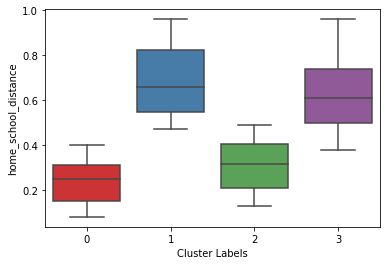

In [90]:
import seaborn as sns
sns.boxplot(x="Cluster Labels", y="home_school_distance", data=samara_grouped_clustering, palette="Set1")

## Consclusions

Analyzing data from each cluster, we can make the following descriptions of the received clusters:

**Cluster 0**

The closest schools from home (mean: 0.243 km)

The closest schools from metro stations (mean: 0.609 km)

No pre-school education (0 vs 21 schools)

No In-depth education (0 vs 21 schools)


**Cluster 1** 

The remotest schools from home (mean: 0.683 km)

The remotest schools from metro stations (mean: 1.710 km)

No pre-school education (0 vs 22 schools)

Almost no In-depth education (4 vs 18 schools)


**Cluster 2**

The almost closest schools from home (mean: 0.311 km)

The almost closest schools from metro stations (mean: 0.779 km)

Some schools with pre-school education (3 schools have vs 5 schools no)

With In-depth education (8 vs 0 schools)


**Cluster 3**

The almost most remote schools from home (mean: 0.639 km)

The almost most remote schools from metro stations (mean: 1.593 km)

With pre-school education (9 vs 0 schools)

Almost In-depth education (1 vs 8 schools)


******



Based on the resulting description, I would exclude from the further consideration:

**Cluster 01* 

**Exclude**. As it’s the possible home locations with remotest schools and without Pre-school and In-depth education


**Cluster 3** 

**Exclude**. As it’s also locations with almost remotest schools and no In-depth education. 
Although the school have pre-school educations, but due to Covid-19 restrictions it is not an available option for the schools
I would leave for the further consideration:

**Cluster 0** 

**Keep**. as it’s the closest schools. At the same time the schools do not have pre-school or In-depth education.

**Cluster 2**

**Keep 100%**. I will definitely keep the cluster as the locations with the school located closely and all the school have In-depth education,
which is definitely an important point for a good education.

Let's exclude **Clusters 1 and 3** and construct and maps for two other clusters:

In [91]:
keep_clusters = samara_grouped_clustering[(samara_grouped_clustering['Cluster Labels'] != 1) & (samara_grouped_clustering['Cluster Labels'] != 3)]
print('size of dataset:', keep_clusters.shape[0])
keep_clusters.head()

size of dataset: 29


,Institution,Cluster Labels,homeLong,homeLat,In-depth study,Pre-school education,station_school_Distance,home_school_distance
1,MBOU School № 37,0,50.160421,53.200836,0,0,0.38,0.15
5,MBOU School number 116 named after Hero of the Soviet Union I.V. Panfilov,0,50.175443,53.199137,0,0,0.26,0.10
22,MBOU School number 25 named after the Kharitonov sisters,2,50.153887,53.201112,1,0,0.75,0.30
25,MBOU School № 132 named after Hero of the Soviet Union Gubanov G.P.,2,50.135048,53.203528,1,1,1.17,0.47
26,MBOU School № 148 named after Hero of the Soviet Union Mikhalev VP,2,50.137232,53.203618,1,0,1.23,0.49


After excluding data of Cluster 1 and 3 we will receive the following map with the possible center home locations:

In [96]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = ['blue', 'brown']

# add Metro/Underground markers to map
for lat, lng, label in zip(underground.latitude, underground.longitude, underground.stationName):
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.8
    ).add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(keep_clusters['homeLat'], keep_clusters['homeLong'], keep_clusters['Institution'], keep_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

And let's transform the center points of possible home locations into areas with the *radius = 1000 meters* (the max allowed distance from home to school) which will define areas for my further searches of apartments: 

In [94]:
search_area = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around the Samara

# add the schools as yellow circles
for lat, lng, label in zip(keep_clusters.homeLat, keep_clusters.homeLong, keep_clusters.Institution):
    folium.Circle(
        [lat, lng],
        radius=1000,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=1.0
    ).add_to(search_area)
    
# add Metro/Underground markers to map
for lat, lng, label in zip(underground.latitude, underground.longitude, underground.stationName):
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.8
    ).add_to(search_area)

    
# display map
search_area

The final report with the full text decription of the Capstone project can be found by the following link:

https://www.dropbox.com/s/fgc2fauvul4j87a/0%20REPORT%20-%20IBM%20Data%20Science%20-%20Final%20Capstone%20Project%20WATSON%20STUDIO.pdf?dl=1
